## Análisis de lag para definición del tamaño de la ventana

In [15]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import bokeh

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.charts import Line, TimeSeries
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

### 1) cargamos los datos desde Yahoo

In [2]:
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

apple = web.DataReader("AAPL", "yahoo", start, end)

In [3]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,102.612183
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.040792
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.083025
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,93.943473
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.440222


In [4]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-01-04 to 2017-04-21
Data columns (total 6 columns):
Open         328 non-null float64
High         328 non-null float64
Low          328 non-null float64
Close        328 non-null float64
Volume       328 non-null int64
Adj Close    328 non-null float64
dtypes: float64(5), int64(1)
memory usage: 17.9 KB


**Open:** is the price of the stock at the begining of the trading day (it need not be the closing price of the previous trading day).

**High:** is the highest price of the stock on that trading day.

**Low:** lowsest price of the stock on that trading day.

**Close:** the price of the stock at closing time.

**Volume:** indicates how many stocks were traded.

**Adjusted close:** is the closing price of the stocks that adjusts the price of the stock for corporate actions.

Could be interesting!!

*While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.*

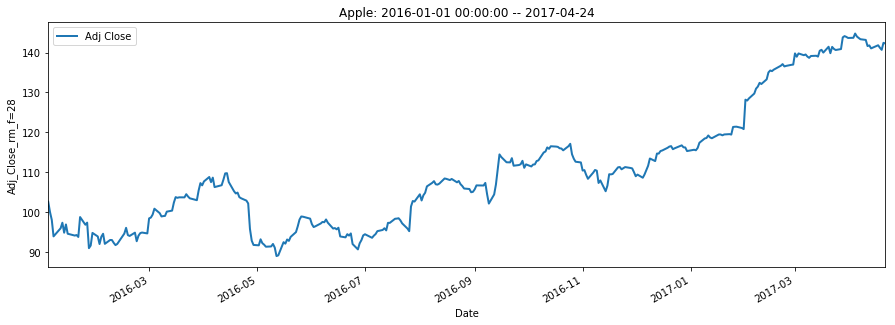

In [35]:
ax = apple[['Adj Close']].plot(figsize=(15,5), 
                               lw=2,
                               title='Apple: {0} -- {1}'.format(start, end),
                              )
ax.set_ylabel(apple.columns[-1])

### 2) Soft models - rolling mean

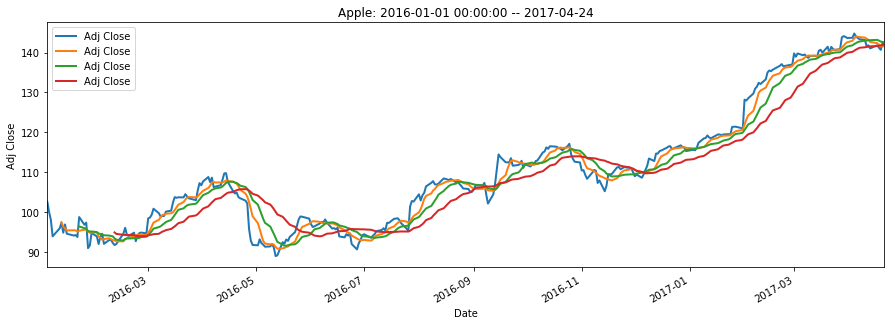

In [6]:
f, ax  = plt.subplots()
apple[['Adj Close']].plot(ax=ax, figsize=(15,5), 
                               lw=2,
                               title='Apple: {0} -- {1}'.format(start, end),
                               
                              )
ax.set_ylabel(apple.columns[-1])

for feq in [7, 14, 28]:
    apple[['Adj Close']].rolling(window=feq).mean().plot(ax=ax, lw=2)

Boken 

1) construir a Pandas DF con los datos 

2) dibujarlos

In [26]:
for feq in [7, 14, 28]:
    apple['Adj_Close_rm_f={0}'.format(feq)] = apple['Adj Close'].rolling(window=feq).mean()

In [28]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close,Adj_Close_rm_f=7,Adj_Close_rm_f=14,Adj_Close_rm_f=28
Date,,,,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,102.612183,NaN,NaN,NaN
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.040792,NaN,NaN,NaN
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.083025,NaN,NaN,NaN
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,93.943473,NaN,NaN,NaN
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.440222,NaN,NaN,NaN


In [31]:
TOOLS = [HoverTool()]
 
p = TimeSeries(apple.ix[:, 5:], title="Apple - Adj Close: ----", 
                   ylabel='Adj Close', xlabel='Date', legend=True, tools=TOOLS)
show(p)

In [33]:
apple.ix[:, 5:].corr()

,Adj Close,Adj_Close_rm_f=7,Adj_Close_rm_f=14,Adj_Close_rm_f=28
Adj Close,1.000000,0.992343,0.980569,0.955155
Adj_Close_rm_f=7,0.992343,1.000000,0.994577,0.972151
Adj_Close_rm_f=14,0.980569,0.994577,1.000000,0.987280
Adj_Close_rm_f=28,0.955155,0.972151,0.987280,1.000000


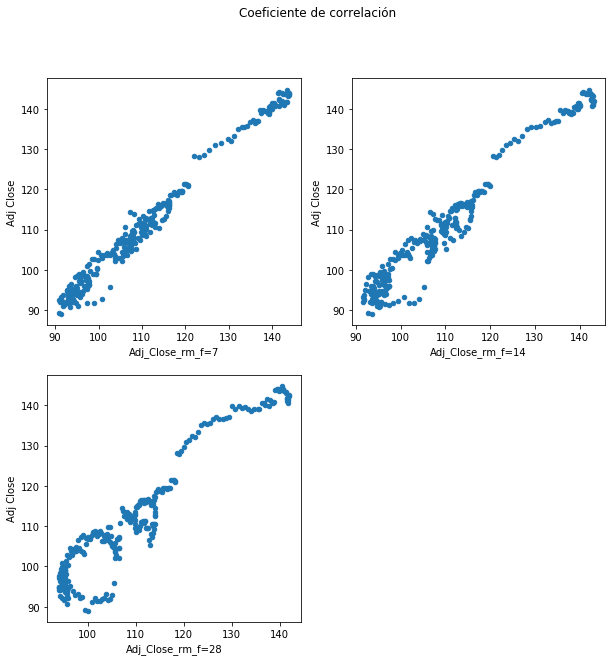

In [37]:
f = plt.figure(figsize=(10,10))
for i, col in enumerate(apple.ix[:,5:].columns[1:]):
    i=i+1
    ax = f.add_subplot(2,2,i)
    apple.plot(ax=ax, kind='scatter', x=col, y='Adj Close')

plt.suptitle('Coeficiente de correlación')

### 3) Machine Learnig - creación de datasets

In [38]:
def features_label(ts, feature_window, horizon, padding=0):
    timesteps = len(ts) - (feature_window + horizon + padding - 1)
    
    features = np.zeros((timesteps, feature_window), dtype = np.float32)
    labels = np.zeros(timesteps, dtype = np.float32)
    
    for t in range(padding, timesteps):
        
        features[t][0:feature_window] = ts[t:t + feature_window]
        
        offset = t + feature_window + horizon - 1
        labels[t] = ts[offset]
        
    labels = labels[:, np.newaxis]
    
    return features, labels

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122412550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122605b00>], dtype=object)

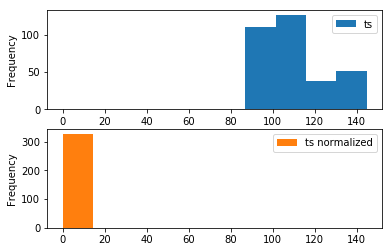

In [39]:
ts = apple['Adj Close'].values

# Normalizamos la serie entre [0,1]
tsNormalized = ts / ts.max()
# Normalizamos con scikit para después poder hacer el inverso
maxMin = MinMaxScaler()
tsNormalized = maxMin.fit_transform(ts)

pd.DataFrame({'ts': ts, 'ts normalized': tsNormalized}). \
    plot(kind='hist', subplots=True, sharex=False, use_index=False)

In [40]:
features, label = features_label(tsNormalized, 7, 1)

print('*Dataset******\nExamples: {0[0]}\nFeatures: {0[1]}\nLabel: {1[1]}'. \
        format(features.shape, label.shape))

*Dataset******
Examples: 321
Features: 7
Label: 1


### 4) Separamos el dataset en train, validation y test

In [41]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.33)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33)

In [54]:
print('Train set: {0:2f} %'.format((x_train.shape[0] / features.shape[0]) * 100))
print('Val set: {0:2f} %'.format((x_val.shape[0] / features.shape[0]) * 100))
print('Test set: {0:2f} %'.format((x_test.shape[0] / features.shape[0]) * 100))

Train set: 44.859813 %
Val set: 22.118380 %
Test set: 33.021807 %


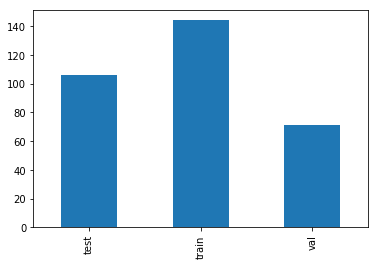

In [42]:
pd.DataFrame({'train': [len(y_train)],
              'val'  : [len(y_val)],
              'test' : [len(y_test)]}).T.plot(kind='bar', legend=False)

### 5) Creamos el modelo

In [43]:
# 1) Definición de hiperparámetros
batch_size = 128
epochs = 20

In [44]:
# 2) Topología del modelo
model = Sequential()
model.add(Dense(14, activation='relu', input_shape=(7,)))
model.add(Dense(1, activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 127.0
Trainable params: 127
Non-trainable params: 0.0
_________________________________________________________________


In [45]:
model.compile(loss='mean_squared_error',
              optimizer=SGD(),
              metrics=['mae'])

In [46]:
history = model.fit(x_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(x_val, y_val))

Train on 144 samples, validate on 71 samples
Epoch 1/20
144/144 [==============================] - 0s - loss: 0.3750 - mean_absolute_error: 0.5015 - val_loss: 0.3022 - val_mean_absolute_error: 0.4285
Epoch 2/20
144/144 [==============================] - 0s - loss: 0.3179 - mean_absolute_error: 0.4531 - val_loss: 0.2556 - val_mean_absolute_error: 0.3841
Epoch 3/20
144/144 [==============================] - 0s - loss: 0.2681 - mean_absolute_error: 0.4076 - val_loss: 0.2130 - val_mean_absolute_error: 0.3421
Epoch 4/20
144/144 [==============================] - 0s - loss: 0.2236 - mean_absolute_error: 0.3639 - val_loss: 0.1807 - val_mean_absolute_error: 0.3107
Epoch 5/20
144/144 [==============================] - 0s - loss: 0.1894 - mean_absolute_error: 0.3293 - val_loss: 0.1536 - val_mean_absolute_error:

In [322]:
def plot_train_val(history):
    #
    # Cuidado !!!!!
    #
    print(history.history.keys())
    loss = history.history['loss']
    val_loss = history.history['mean_absolute_error']
    acc = history.history['val_loss']
    acc_val = history.history['val_mean_absolute_error']
    
    epochs = range(len(loss)); print(epochs)
    
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
    ax1.plot(epochs, loss, c='darkorange', lw=2, label='Training set')
    ax1.plot(epochs, val_loss, c='dodgerblue', lw=2, label='Validation set')
    ax1.set_ylabel('Loss - MAE')
    ax1.legend()
    ax2.plot(epochs, acc, c='darkorange', lw=2, label='Training set')
    ax2.plot(epochs, acc_val, c='dodgerblue', lw=2, label='Validation set')
    ax2.set_ylabel('MAE'); ax2.set_xlabel('Epochs')
    ax2.legend()

dict_keys(['loss', 'mean_absolute_error', 'val_mean_absolute_error', 'val_loss'])
range(0, 20)


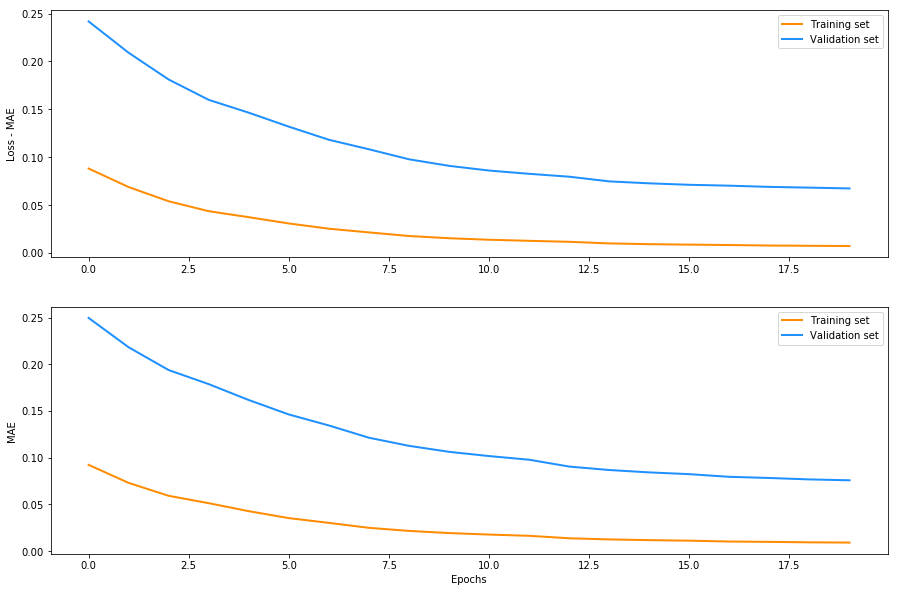

In [323]:
plot_train_val(history)

In [47]:
pred = model.predict(x_test)

          pred      real
pred  1.000000  0.977911
real  0.977911  1.000000


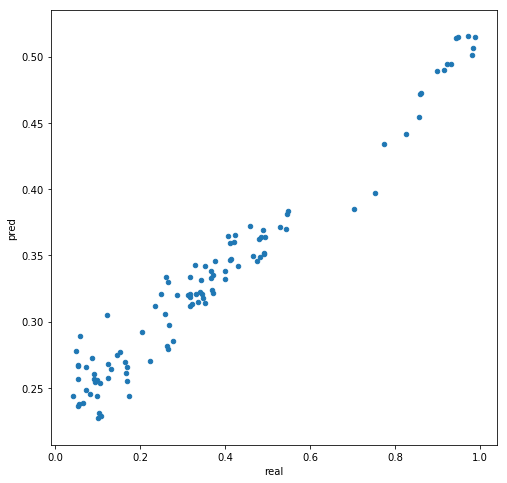

In [48]:
df_pred = pd.DataFrame({'real': y_test.flatten(),
                        'pred': pred.flatten()})

print(df_pred.corr())

df_pred.plot(kind='scatter', x='real', y='pred',
             figsize=(8,8))

In [49]:
results = pd.DataFrame({'y_real': maxMin.inverse_transform(y_test).flatten(),
                        'y_pred': maxMin.inverse_transform(pred).flatten()})
results.head()

,y_pred,y_real
0,107.071449,109.584885
1,104.574036,103.776154
2,106.552208,107.786880
3,106.891762,102.904579
4,106.880249,107.489708


In [50]:
from sklearn.metrics.regression import mean_squared_error
mean_squared_error(results.y_pred.values, results.y_real.values)

121.54927

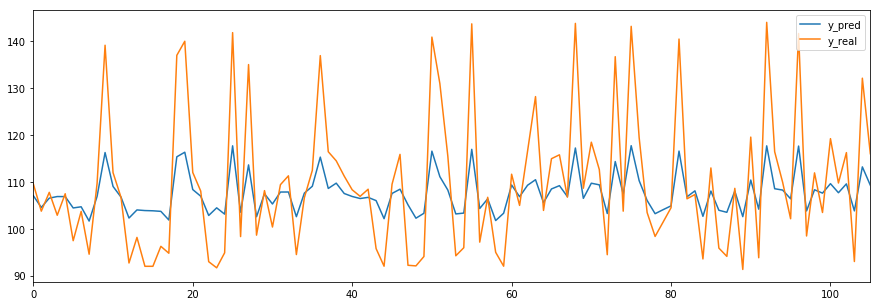

In [51]:
results.plot(figsize=(15,5))

In [52]:
TOOLS = [HoverTool()]
p = TimeSeries(results, title="Apple - Adj Close: ----", 
                   ylabel='Adj Close', xlabel='Date', legend=True, tools=TOOLS)
show(p)

In [53]:
results.ix[105:,:]

,y_pred,y_real
105,109.306183,116.018753


# 